## Deep Convolutional Generative Adversarial Networks Trained on Fashion MNIST

In [1]:
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.optimizers import Adam



from IPython import display

Using TensorFlow backend.


In [0]:
(train_imgs, train_lab), (_, _) = tf.keras.datasets.fashion_mnist.load_data()

train_imgs = train_imgs / 127.5 - 1.
train_imgs = np.expand_dims(train_imgs, axis=3)

BUFFER_SIZE = 60000
BATCH_SIZE = 256
EPOCHS = 60

img_rows = 28
img_cols = 28
channels = 1
img_shape = (img_rows, img_cols, channels)
latent_dim = 100

In [0]:
train_set = tf.data.Dataset.from_tensor_slices(train_imgs).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [4]:
def build_generator():

    model = Sequential()

    model.add(Dense(256, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(np.prod(img_shape), activation='tanh'))
    model.add(Reshape(img_shape))

    model.summary()

    noise = Input(shape=(latent_dim,))
    img = model(noise)

    return Model(noise, img)
  
generator = build_generator()
noise = tf.random.normal([1,100])
generated_img = generator(noise)





Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense_2 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
_________________________________________________________________
dense_3 (Dense)              (None, 1024)         

In [0]:
def discriminator_model():

    model = Sequential()

    model.add(Flatten(input_shape=img_shape))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()

    img = Input(shape=img_shape)
    validity = model(img)

    return Model(img, validity)

In [6]:
discriminator = discriminator_model()

decision_output = discriminator(generated_img)

print(decision_output)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
________________________________________________

In [0]:
def generate_and_show_images(epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, latent_dim))
        gen_imgs = generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        plt.show()
        plt.close()


In [0]:
def train(X_train, epochs, combined, batch_size=128, sample_interval=50):

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            #  Train Discriminator

            # Select a random batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            noise = np.random.normal(0, 1, (batch_size, latent_dim))

            # Generate a batch of new images
            gen_imgs = generator.predict(noise)

            # Train the discriminator
            d_loss_real = discriminator.train_on_batch(imgs, valid)
            d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            #  Train Generator
            noise = np.random.normal(0, 1, (batch_size, latent_dim))

            # Train the generator (to have the discriminator label samples as valid)
            g_loss = combined.train_on_batch(noise, valid)

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            if epoch % sample_interval == 0:
                generate_and_show_images(epoch)



Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
________________________________________________

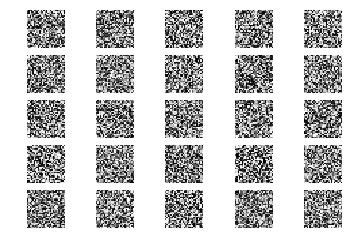

1 [D loss: 0.677941, acc.: 50.39%] [G loss: 0.445380]
2 [D loss: 0.681727, acc.: 51.17%] [G loss: 0.407046]
3 [D loss: 0.758727, acc.: 50.00%] [G loss: 0.368509]
4 [D loss: 0.779854, acc.: 50.00%] [G loss: 0.322569]
5 [D loss: 0.853607, acc.: 50.00%] [G loss: 0.294899]
6 [D loss: 0.874873, acc.: 50.00%] [G loss: 0.290368]
7 [D loss: 0.947799, acc.: 50.00%] [G loss: 0.272693]
8 [D loss: 0.932544, acc.: 50.00%] [G loss: 0.261653]
9 [D loss: 0.930955, acc.: 50.00%] [G loss: 0.241523]
10 [D loss: 0.981586, acc.: 50.00%] [G loss: 0.247153]
11 [D loss: 0.978273, acc.: 50.00%] [G loss: 0.239059]
12 [D loss: 0.981363, acc.: 50.00%] [G loss: 0.236333]
13 [D loss: 1.001472, acc.: 50.00%] [G loss: 0.237657]
14 [D loss: 1.020757, acc.: 50.00%] [G loss: 0.234116]
15 [D loss: 1.047579, acc.: 50.00%] [G loss: 0.239713]
16 [D loss: 1.013590, acc.: 50.00%] [G loss: 0.231435]
17 [D loss: 1.051192, acc.: 50.00%] [G loss: 0.227964]
18 [D loss: 1.016201, acc.: 50.00%] [G loss: 0.245234]
19 [D loss: 1.03600

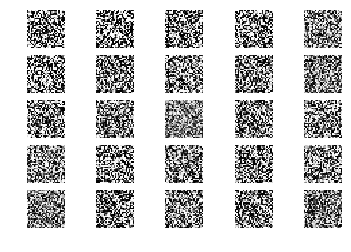

51 [D loss: 1.273289, acc.: 50.00%] [G loss: 0.212087]
52 [D loss: 1.238062, acc.: 50.39%] [G loss: 0.189858]
53 [D loss: 1.204220, acc.: 50.00%] [G loss: 0.200021]
54 [D loss: 1.201599, acc.: 50.00%] [G loss: 0.223464]
55 [D loss: 1.143780, acc.: 50.00%] [G loss: 0.224913]
56 [D loss: 1.201265, acc.: 49.22%] [G loss: 0.203223]
57 [D loss: 1.195244, acc.: 50.00%] [G loss: 0.223172]
58 [D loss: 1.188702, acc.: 50.00%] [G loss: 0.204887]
59 [D loss: 1.186843, acc.: 49.61%] [G loss: 0.212711]


In [9]:
optimizer = Adam(0.0002, 0.5)

discriminator = discriminator_model()
discriminator.compile(loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy'])

z = Input(shape=(latent_dim,))
generator = build_generator()
img = generator(z)

combined = Model(z, discriminator(img))
combined.compile(loss='binary_crossentropy', optimizer=optimizer)

train(train_imgs, EPOCHS, combined=combined)